In [24]:
import pandas as pd
import numpy as np

In [4]:
data = pd.DataFrame({'c1': [3, 10, 5, 7, 1, 9, 69], 'c2': [15, 16, 14, 100, 19, 11, 8], 'c3': [20, 15, 18, 21, 120, 27, 29]})

In [5]:
data

,c1,c2,c3
0,3,15,20
1,10,16,15
2,5,14,18
3,7,100,21
4,1,19,120
5,9,11,27
6,69,8,29


### 异常值检测

* 用箱体图检测
![./images/ch11-1.png](./images/ch11-1.png)


* 用正态分布。如：认为数值与均值距离超过2个标准差则认为可以是异常值

$ x^{*} = \frac{x - mean}{std} $

<AxesSubplot:>

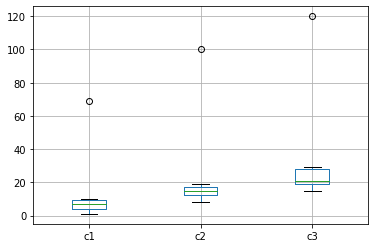

In [6]:
data.boxplot()

In [9]:
a = pd.DataFrame()
for i in data.columns:
    z = (data[i] - data[i].mean()) / data[i].std()   # Z-score标准化
    a[i] = abs(z) > 2   # 是否超过两个标准差

In [10]:
a

,c1,c2,c3
0,False,False,False
1,False,False,False
2,False,False,False
3,False,True,False
4,False,False,True
5,False,False,False
6,True,False,False


### 数据的分箱

一般用于对连续型变量离散化

* 等宽分箱：每个分箱的差值相等
* 等深分箱：每个分箱中的样本数一致

In [11]:
data = pd.DataFrame([[22, 1], [25, 1], [20, 0], [35, 0], [32, 1], [38, 0], [50, 0], [46, 1]], columns=['年龄', '是否违约'])

data

In [13]:
data_cut = pd.cut(data['年龄'], 3)

In [14]:
data_cut

0    (19.97, 30.0]
1    (19.97, 30.0]
2    (19.97, 30.0]
3     (30.0, 40.0]
4     (30.0, 40.0]
5     (30.0, 40.0]
6     (40.0, 50.0]
7     (40.0, 50.0]
Name: 年龄, dtype: category
Categories (3, interval[float64, right]): [(19.97, 30.0] < (30.0, 40.0] < (40.0, 50.0]]

### 特征筛选

* WOE值
WOE——Weight of Evidence，反映某一变量的特征区分度。值越大，特征区分度越高

计算步骤：
1. 先分箱
2. 分箱后，第i个分箱内数据的WOE值计算： $WOE_i = \ln \frac{P_{y_i}}{P_{n_i}}，其中 P_{y_i} = \frac{y_i}{y_T}, P_{n_i} = \frac{n_i}{n_T}$

以客户违约预测模型为例（标签为客户是否违约）：

$P_{y_i}$是第i个分箱中违约客户占整个样本中违约客户的比例

$P_{n_i}$是第i个分箱中未违约客户占整个样本中未违约客户的比例


* IV值

Information Value（信息量），能较好反映特征变量的预测能力。特征变量IV值越大，其价值越大。

$IV_i = (P_{y_i} - P_{n_i})WOE_i$

然后对各个分箱的IV值求和即可得这个特征变量的IV值： $IV=\sum\limits_{i}^n IV_i$


In [21]:
cut_group_all = data['是否违约'].groupby(data_cut).count()
cut_y = data['是否违约'].groupby(data_cut).sum()
cut_n = cut_group_all - cut_y

In [22]:
df = pd.DataFrame()
df['总数'] = cut_group_all
df['坏样本'] = cut_y
df['好样本'] = cut_n

In [23]:
df

,总数,坏样本,好样本
年龄,,,
"(19.97, 30.0]",3,2,1
"(30.0, 40.0]",3,1,2
"(40.0, 50.0]",2,1,1


In [27]:
df['坏样本%'] = df['坏样本'] / df['坏样本'].sum()
df['好样本%'] = df['好样本'] / df['好样本'].sum()

df['WOE'] = np.log(df['坏样本%'] / df['好样本%'])
df = df.replace({'WOE': {np.inf: 0, -np.inf: 0}})

df['IV'] = df['WOE'] * (df['坏样本%'] - df['好样本%'])

In [28]:
df

,总数,坏样本,好样本,坏样本%,好样本%,WOE,IV
年龄,,,,,,,
"(19.97, 30.0]",3,2,1,0.50,0.25,0.693147,0.173287
"(30.0, 40.0]",3,1,2,0.25,0.50,-0.693147,0.173287
"(40.0, 50.0]",2,1,1,0.25,0.25,0.000000,0.000000


In [29]:
iv = df['IV'].sum()

In [30]:
iv

0.34657359027997264

### 特征线性相关或近似线性相关判断（多重共线性）

线性相关： $\alpha_1 X_1 + \alpha_2 X_2 + ... + \alpha_n X_n = 0，其中\alpha_i 不全为0$

近似线性相关： $\alpha_1 X_1 + \alpha_2 X_2 + ... + \alpha_n X_n + v = 0，其中\alpha_i 不全为0，v为误差随机项$

1. 测试皮尔逊相关系数
2. 方差膨胀系数法（VIF检验）

$X_i$对应的$VIF_i = \frac{1}{1 - R^2}$, 其中$R^2$为R-squred值 （Chapter 3）

一般认为$VIF_i < 10$，该变量与其余变量直接不存在多重共线性；$10 \leq VIF_i < 100$则较强多重共线性；$VIF_i \geq 100$则严重多重共线性

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(df.values, df.columns.get_loc(i)) for i in df.columns]

/opt/anaconda3/envs/hoho_RL/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [33]:
vif

[inf, inf, inf, inf, inf, inf, 5.500000000000002]

In [35]:
# smote过采样

data = pd.read_excel('./data/信用卡数据.xlsx')
data.head()

,编号,年龄,负债比率,月收入,贷款数量,家属人数,分类
0,1,29,0.22,7800,1,3,0
1,2,52,0.46,4650,1,0,0
2,3,28,0.10,3000,0,0,0
3,4,29,0.20,5916,0,0,0
4,5,27,1.28,1300,0,0,1


In [36]:
X = data.drop(columns='分类')
y = data['分类']

In [37]:
from collections import Counter

Counter(y)

Counter({0: 1000, 1: 100})

In [38]:
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 1.2 MB/s eta 0:00:000:00:010:00:01:01


In [39]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_smotesampled, y_smotesampled = smote.fit_resample(X, y)

In [40]:
Counter(y_smotesampled)

Counter({0: 1000, 1: 1000})